# Introducción al Machine Learning - Ricardo Talavera Data Scientist
## Taller: Implementación de ensamblaje "Rotation Bagged Trees"
### Propósito de la actividad
En esta actividad  ponemos en práctica la implementación de un modelo de ensamblaje basado en árboles. En particular, se implementará el ensamblaje "Rotation Bagged Trees".

### Instrucciones generales

Número de árboles: Se utiliza adecuadamente el parámetro “numArboles” de acuerdo a como fue especificado en el enunciado. 

Rotación de predictores: El código rota correctamente los predictores.

Coherencia en los ángulos de rotación utilizados en train y en test para cada árbol: El código debe utilizar en test las mismas rotaciones que utilizó en train para cada árbol estimado. 

Coherencia en los predictores utilizados en train y en test para cada árbol: El código debe utilizar en test los mismos predictores que utilizó en train para cada árbol estimado. 

Medición del desempeño: El código permite calcular de manera correcta el MSE en la muestra de evaluación.


### Diversificación como principio para ensamblar

Los ensamblajes de modelos predictivos son útiles para combinar modelos que, por separado, no tendrían un buen desempeño. Por ejemplo, se suelen utilizar diferentes técnicas de ensamblaje en árboles de decisión para que el modelo resultante tenga un gran poder predictivo.

De esta manera, los algoritmos de ensamblaje (como bagging o boosting) se benefician de las diversas características que resultan de los modelos de árboles individualmente. Por lo anterior, la diversificación es un principio fundamental para mejorar el desempeño predictivo en el ensamblaje de modelos, por lo cual encontrar formas de diversificar los algoritmos predictivos se vuelve una tarea fundamental.

De esta manera, en este notebook se implementará un código que permita aplicar diversificación en el ensamblaje de árboles de decisión de una manera inédita: Rotation Bagged Trees.

### Librerías a importar

A continuación se muestran los comandos a ejecutar para poder implementar los procedimientos de este notebook:

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

### Cargando los datos

En primer lugar, cargaremos los datos a usar en este Notebook que corresponden a la base de datos "Diabetes" del paquete "sklearn". Para ello, ejecutaremos el siguiente código:

In [2]:
XTotal, yTotal = datasets.load_diabetes(return_X_y=True)

In [3]:
XTotal.shape

(442, 10)

In [4]:
yTotal.shape

(442,)

Luego, partiremos la base de datos en una sección de train y otra de test de la siguiente manera: utilizaremos el 67% de los datos para entrenamiento y el 33% restante para evaluación.

In [5]:
XTrain, XTest, yTrain, yTest = train_test_split(XTotal, yTotal, test_size=0.33, random_state=0)

Ahora, procederemos a presentar conceptos importantes para el desarrollo.

### Estimando un árbol de regresión

A continuación se muestra un procedimiento para la estimación de un árbol de regresión para la base de datos descargada:

In [6]:
arbol = DecisionTreeRegressor()
arbol  = arbol.fit(XTrain, yTrain)

Luego, es posible realizar predicciones sobre la muestra de evaluación y calcular su desempeño:

In [7]:
prediccion=arbol.predict(XTest)
MSEArbol=np.average(np.square(prediccion-yTest))
print("El MSE del modelo en la muestra de evaluación es igual a:")
print(MSEArbol)

El MSE del modelo en la muestra de evaluación es igual a:
5216.8493150684935


### Rotaciones en $R^2$

Las rotaciones son un tipo particular de transformación lineal que, al aplicarse sobre un espacio, cambia la orientación de un vector preservando su longitud. En particular, si se quiere rotar un vector en un ángulo $\theta$, la matriz $A(\theta)$ que representa esta transformación lineal es definida de la siguiente forma:

$$A=\begin{pmatrix}
Cos(\theta) & -Sen(\theta) \\
Sin(\theta) & Cos(\theta) 
\end{pmatrix}$$

De esta manera, si se quisiera rotar 90 grados el vector $v=\begin{pmatrix}
1 \\
1  
\end{pmatrix}$, entonces esto correspondería a multiplicarlo por la matriz $A(\frac{\pi}{2})$ de la siguiente forma:

$$A(\frac{\pi}{2})v=\begin{pmatrix}
Cos(\frac{\pi}{2}) & -Sen(\frac{\pi}{2}) \\
Sin(\frac{\pi}{2}) & Cos(\frac{\pi}{2}) 
\end{pmatrix} \begin{pmatrix}
1 \\
1  
\end{pmatrix}= \begin{pmatrix}
0 & -1 \\
1 & 0 
\end{pmatrix}\begin{pmatrix}
1 \\
1  
\end{pmatrix}=\begin{pmatrix}
-1 \\
1  
\end{pmatrix}$$

A continuación se muestra el código que realiza esta operación y la representación gráfica:

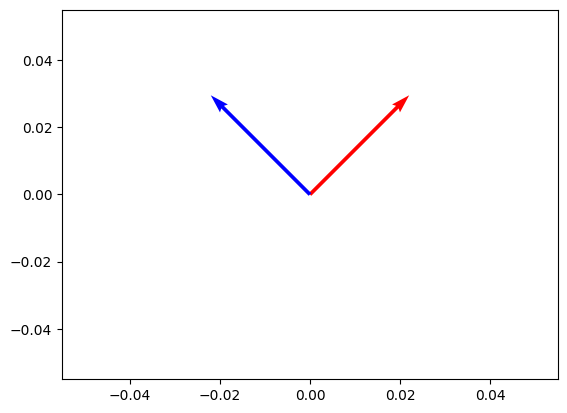

In [8]:
vectorOriginal=[1,1] #En rojo

theta = np.radians(90)
A = np.array(((np.cos(theta), -np.sin(theta)), (np.sin(theta), np.cos(theta))))

vectorRotado=np.matmul(A, vectorOriginal) #En azul

V = np.array([vectorOriginal, vectorRotado])
origin = np.array([[0, 0],[0, 0]])

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b'],scale=5)
plt.show()

### Generación de números aleatorios

Ahora bien, para el código que deberán desarrollar al final de este archivo, será útil la implementación de un generador de números aleatorios (RNG por sus siglas en inglés).

En particular se necesitarán dos tipos de RNG: uno para una variable aleatoria uniforme discreta y otra para una variable aleatoria uniforme continua.

En primer lugar, el código para generar $nRNG$ cantidad de variables aleatorias uniformes continuas entre $a$ y $b$ con $a<b$ es:

In [9]:
a=0
b=1
nRNG=10
np.random.uniform(a,b,nRNG)

array([0.10024053, 0.71087651, 0.20057519, 0.18868282, 0.36600388,
       0.90291302, 0.18997042, 0.26736745, 0.51757254, 0.78215109])

Ahora bien, si se quiere generar $nRNG$ cantidad de variables aleatorias discretas entre $a$ y $b$ con $a<b$, entonces puede usarse el siguiente código:

In [10]:
a=0
b=10
nRNG=3
np.random.choice(range(0,b+1), size=nRNG, replace=False)

array([5, 4, 8])

### Implementación de código para Rotation Bagged Trees

A continuación escribimos una función que implemente Rotation Bagged Trees. Para ello, hacemos que la función reciba como parámetros la matriz de predictores de entrenamiento, la variable de respuesta de entrenamiento, la matriz de predictores de evaluación, la variable de respuesta de evaluación y un parámetro llamado "numArboles" que corresponde al número de árboles que se deben utilizar en el ensamblaje.
El código entrena la cantidad de árboles de decisión especificada, utilizando en cada uno de ellos únicamente dos predictores escogidos aleatoriamente. Una vez han sido escogidos los dos predictores a utilizar para cada árbol, se escoge, también para cada árbol, un ángulo de manera aleatoria entre 0 y $2\pi$ para rotar los predictores y estimar el modelo con los predictores rotados.
Posteriormente, se realiza la predicción en test y se promedian los resultados de todos los árboles para obtener la salida  del ensamblaje.
Finalmente, la función arroja el MSE de la muestra de test.

In [11]:
XTotal.shape

(442, 10)

In [12]:
def rotation_bagged_trees(XTrain,yTrain,XTest,yTest,numArboles):

    #Inicializo arreglo de predicciones 
    ypred = np.zeros_like(yTest)
    
    #Entrenamiento de los arboles de decisión
    for i in range(numArboles):
        #Seleccion de dos predictores aleatorios
        indices = np.random.choice(XTrain.shape[1], size=2, replace=False)
        X_train_subset = XTrain[:, indices]
        X_test_subset = XTest[:, indices]

        # Generación de un ángulo aleatorio entre 0 y 2*pi
        angulo = np.random.uniform(low=0, high=2*np.pi)

        # Rotación de los predictores
        rotacion = np.array([[np.cos(angulo), -np.sin(angulo)],
                             [np.sin(angulo), np.cos(angulo)]])
        X_train_rotado = X_train_subset.dot(rotacion)
        X_test_rotado = X_test_subset.dot(rotacion)

        # Entrenamiento del árbol de decisión
        clf = DecisionTreeRegressor()
        clf.fit(X_train_rotado, yTrain)

        # Predicción con el árbol de decisión
        y_pred_arbol = clf.predict(X_test_rotado)

        # Acumulación de las predicciones de todos los árboles
        ypred += y_pred_arbol

    # Cálculo del promedio de las predicciones
    ypred /= numArboles

    # Cálculo del MSE
    mse = np.mean((yTest - ypred)**2)

    return mse

    

In [31]:
mse = rotation_bagged_trees(XTrain,yTrain,XTest,yTest,100)

In [32]:
mse_lista=[]
mse_lista.append(("Rotation Bagged Trees",mse))

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

dtc = DecisionTreeRegressor()

dtc.fit(XTrain,yTrain)

y_pred = dtc.predict(XTest)
mse_lista.append(("Decision Tree",mean_squared_error(yTest,y_pred)))

In [34]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(XTrain,yTrain)

y_pred_rf = rf.predict(XTest)
mse_lista.append(("Random Forest",mean_squared_error(yTest,y_pred_rf)))

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

boosting = GradientBoostingRegressor()

boosting.fit(XTrain,yTrain)

y_pred_boosting = boosting.predict(XTest)
mse_lista.append(("Boosting",mean_squared_error(yTest,y_pred_boosting)))

In [37]:
from sklearn.ensemble import BaggingRegressor

bagging = BaggingRegressor()

bagging.fit(XTrain,yTrain)

y_pred_bagging = bagging.predict(XTest)
mse_lista.append(("Bagging",mean_squared_error(yTest,y_pred_bagging)))

In [38]:
mse_lista

[('Rotation Bagged Trees', 3545.9856159731653),
 ('Decision Tree', 5033.821917808219),
 ('Random Forest', 3637.059450684932),
 ('Boosting', 3579.447853372689),
 ('Bagging', 3986.764863013699)]

In [39]:
plt.scatter(mse_lista)

TypeError: scatter() missing 1 required positional argument: 'y'